# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- <b>Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.</b><br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

`utils.py` is a file where there are some methods used in this and the other notebooks generated for the project.

In [1]:
import json
import pandas as pd
from utils import *

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

# loading the match data
matches={}
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
players_df = pd.DataFrame(players)

events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

matches_df = {
    'Italy': pd.DataFrame(matches['Italy']),
    'England': pd.DataFrame(matches['England']),
    'Germany': pd.DataFrame(matches['Germany']),
    'France': pd.DataFrame(matches['France']),
    'Spain': pd.DataFrame(matches['Spain']),
    'European_Championship': pd.DataFrame(matches['European_Championship']),
    'World_Cup': pd.DataFrame(matches['World_Cup'])
}

### Some data preparation

With the function `prepare_players`, only the columns `playerId` and `role` of the `players_df` DataFrame are kept, in order to use this information to make further analysis, based on the role of each player. Look at the `utils.py` file for further information.

In [4]:
players_df = prepare_players(players_df)

All the events with _Goal Kick_ and _Save attempt_ are removed from all the DataFrames, since they all have a dummy value as a starting position, which can be either {'y': 0, 'x': 0} or {'y': 100, 'x': 100} and they would influence and modify the real distance traveled by goalkeepers. (Reference: https://dataglossary.wyscout.com/goal_kick/).

In [5]:
events_to_check = pd.DataFrame()
for nation in events_df:
    goal_kick_events = events_df[nation][(events_df[nation]['subEventName'] == 'Goal kick')]
    save_attempt_events = events_df[nation][(events_df[nation]['eventName'] == 'Save attempt')]
    events_to_check = pd.concat([events_to_check, goal_kick_events, save_attempt_events])

In [6]:
for row in events_to_check.iterrows():
    if not (row[1]['positions'][0] == {'y': 0, 'x': 0} or row[1]['positions'][0] == {'y': 100, 'x': 100}):
        print(True)

As expected, all the events with _Goal kick_ as `subEventName` and all the events with _Save attempt_ as `eventName` have as starting position dummy values, so for the analysis purpose they are noise and for this reason removed from all the DataFrames.

In [7]:
for nation in events_df:
    events_df[nation] = events_df[nation][(events_df[nation]['subEventName'] != 'Goal kick')]
    events_df[nation] = events_df[nation][(events_df[nation]['eventName'] != 'Save attempt')]

In order to analyze and get hint and interesting information about each competition, they all are first analyzed separately. In the end of the notebook is present the total distance distribution.

## Italian first division

In [16]:
italian_events_df = prepare_events(extract_events(events_df, 'Italy'))

In [17]:
events_players_df = pd.merge(italian_events_df, players_df, on='playerId', how='left')

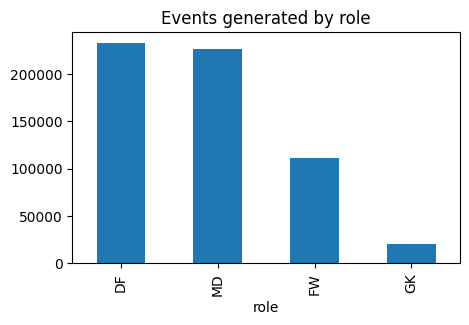

In [18]:
events_players_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')

plt.show()

In [19]:
events_players_distances_df = compute_distance(events_players_df)

In [20]:
italian_tmp_df = sum_distances(events_players_distances_df)

In [21]:
distances_count = count_distances(italian_tmp_df)

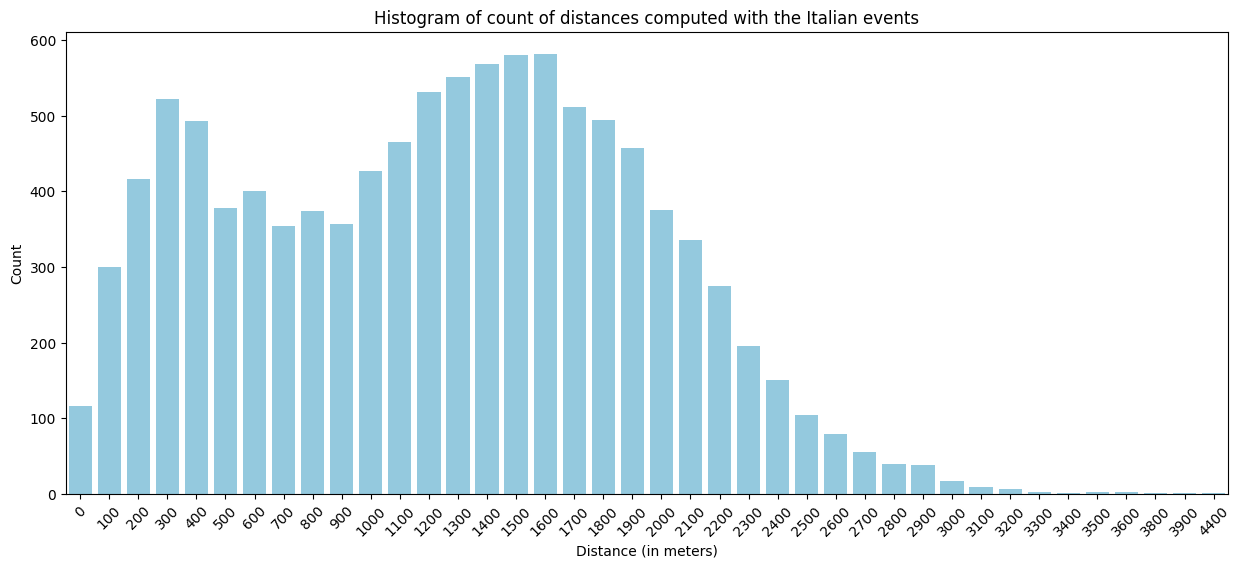

In [22]:
plot_histogram(distances_count, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of count of distances computed with the Italian events')

In [23]:
italian_players_role_distances_df = pd.merge(italian_tmp_df, players_df, on='playerId', how='left')

In [24]:
players_role_distances_df = group_by_distance_role(italian_players_role_distances_df)

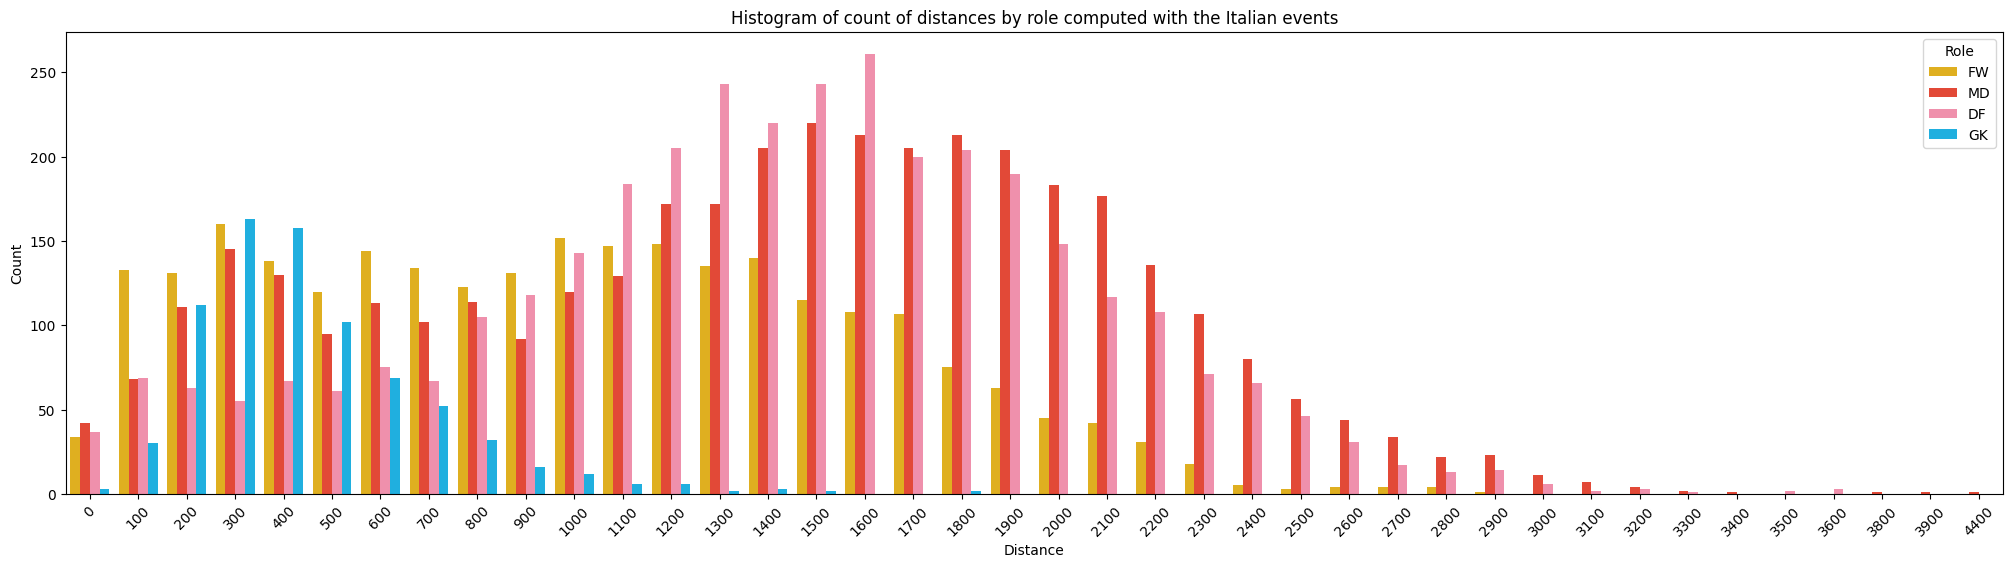

In [25]:
plot_histogram_per_role(players_role_distances_df, 'Histogram of count of distances by role computed with the Italian events')

In [26]:
# loading the matches data
with open('./data/matches/matches_Italy.json') as json_data:
        italian_matches = pd.DataFrame(json.load(json_data))

In [27]:
substitutions = {}
for match in italian_matches.iterrows():
    for key in list(match[1]['teamsData']):
        for sub in match[1]['teamsData'][key]['formation']['substitutions']:
            if match[1]['wyId'] in substitutions:
                substitutions[match[1]['wyId']].append(sub['playerIn'])
            else:
                substitutions[match[1]['wyId']] = [sub['playerIn']]

In [28]:
# removes all the events generated by the players that have been substituted
filtered_df = pd.DataFrame()

for match, player_ids in substitutions.items():
    filtered_df = pd.concat([filtered_df, italian_events_df[(italian_events_df['matchId'] == match) & (italian_events_df['playerId'].isin(player_ids))]])

In [29]:
italian_events_no_subs_df = italian_events_df.drop(list(filtered_df.index))

In [30]:
italian_events_no_subs_df = pd.merge(italian_events_no_subs_df, players_df, on='playerId', how='left')

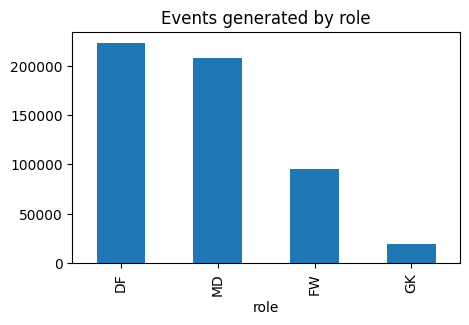

In [31]:
italian_events_no_subs_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')

plt.show()

In [32]:
events_players_distances_no_sub_df = compute_distance(italian_events_no_subs_df)

In [33]:
italian_tmp_no_sub_df = sum_distances(events_players_distances_no_sub_df)

In [34]:
distances_count_no_sub = count_distances(italian_tmp_no_sub_df)

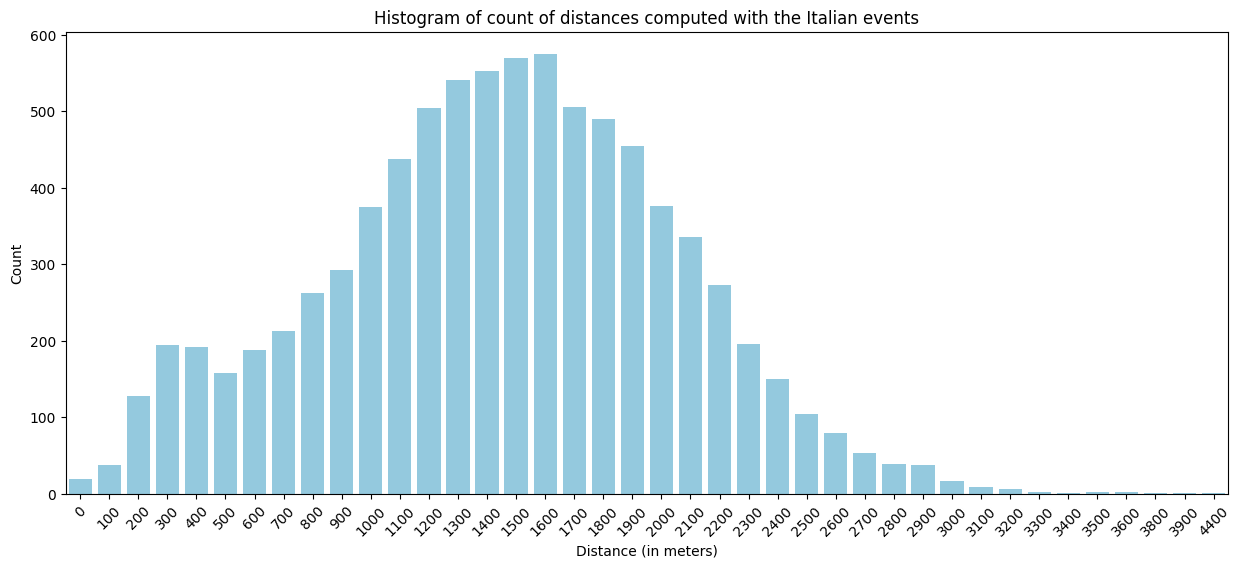

In [35]:
plot_histogram(distances_count_no_sub, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of count of distances computed with the Italian events')

In [36]:
italian_players_role_distances_no_sub_df = pd.merge(italian_tmp_no_sub_df, players_df, on='playerId', how='left')

In [37]:
players_role_distances_no_sub_df = group_by_distance_role(italian_players_role_distances_no_sub_df)

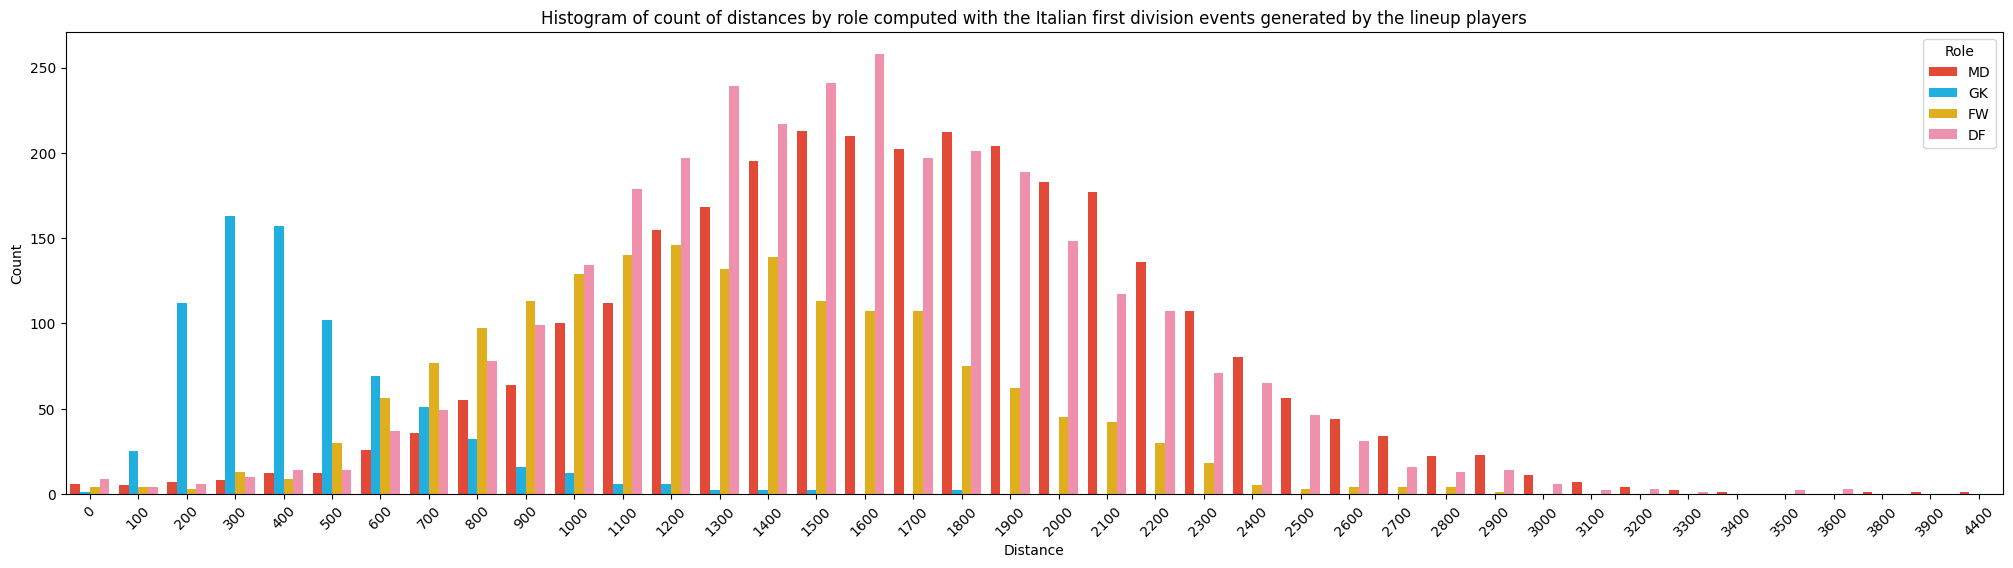

In [38]:
plot_histogram_per_role(players_role_distances_no_sub_df, 'Histogram of count of distances by role computed with the Italian first division events generated by the lineup players')

In [39]:
#filtered_df is the DataFrame containing only the events generated by the players that have been substituted
italian_events_subs_df = pd.merge(filtered_df, players_df, on='playerId', how='left')

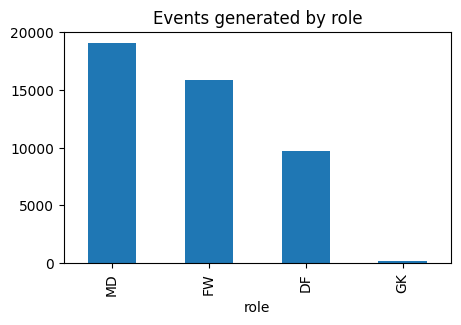

In [40]:
italian_events_subs_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')

plt.show()

In [41]:
events_players_distances_sub_df = compute_distance(italian_events_subs_df)

In [42]:
italian_tmp_sub_df = sum_distances(events_players_distances_sub_df)

In [43]:
distances_count_sub = count_distances(italian_tmp_sub_df)

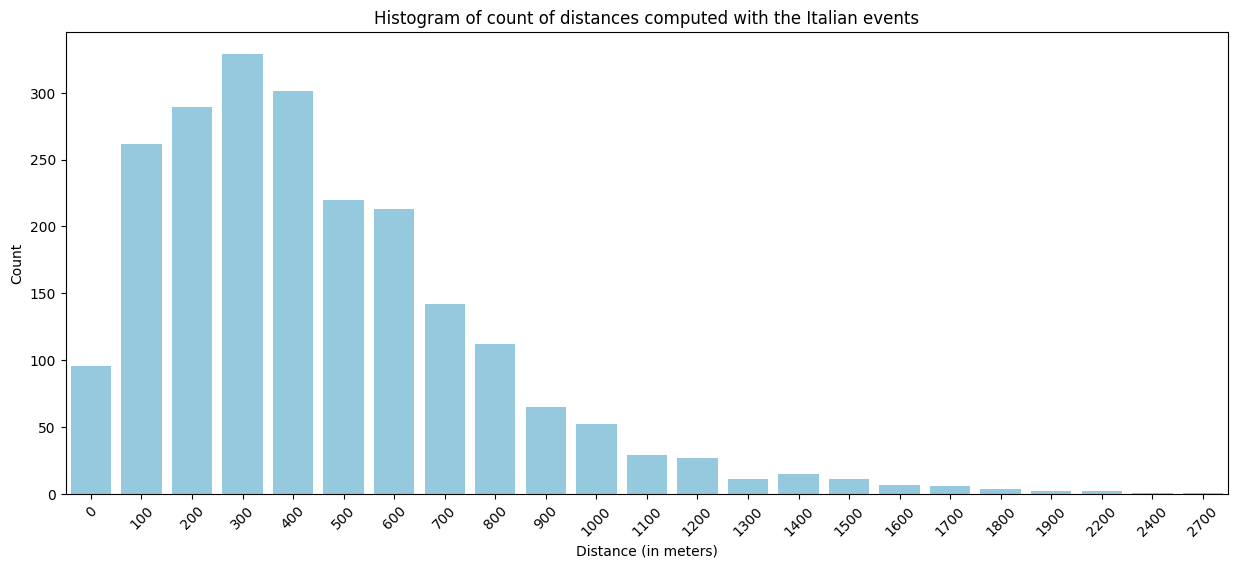

In [44]:
plot_histogram(distances_count_sub, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of count of distances computed with the Italian events')

In [45]:
italian_players_role_distances_sub_df = pd.merge(italian_tmp_sub_df, players_df, on='playerId', how='left')

In [46]:
players_role_distances_sub_df = group_by_distance_role(italian_players_role_distances_sub_df)

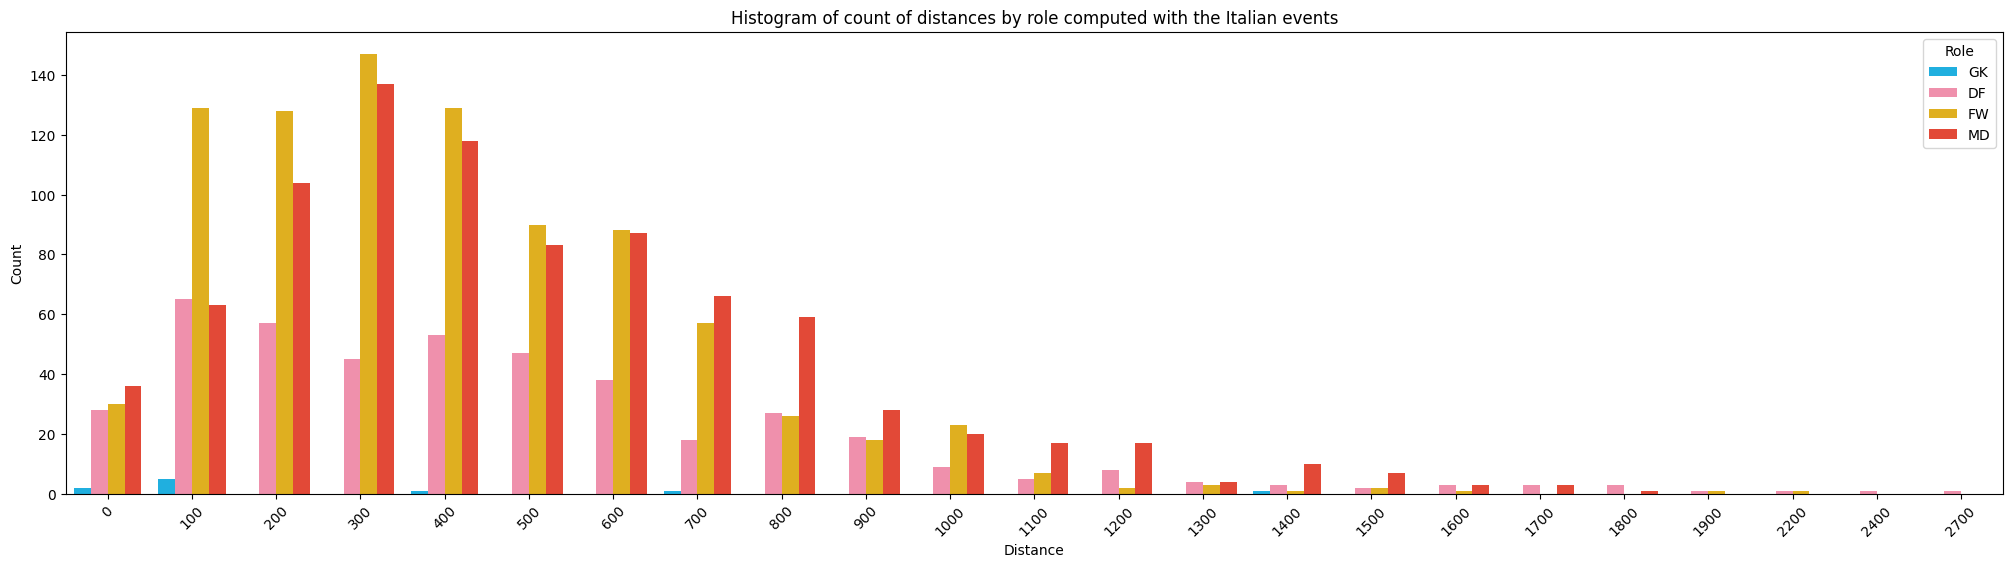

In [47]:
plot_histogram_per_role(players_role_distances_sub_df, 'Histogram of count of distances by role computed with the Italian events')

## English first division analysis

In [ ]:
english_events_df = prepare_events(extract_events(events_df, 'England'))

In [ ]:
events_players_df = pd.merge(english_events_df, players_df, on='playerId', how='left')

In [ ]:
events_players_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')

plt.show()

In [ ]:
events_players_distances_df = compute_distance(events_players_df)

In [ ]:
english_tmp_df = sum_distances(events_players_distances_df)

In [ ]:
distances_count = count_distances(english_tmp_df)

In [ ]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Histogram of count of distances computed with the English events')

In [ ]:
english_players_role_distances_df = pd.merge(english_tmp_df, players_df, on='playerId', how='left')

In [ ]:
players_role_distances_df = group_by_distance_role(english_players_role_distances_df)

i difensori vengono raramente sostituiti, infatti si può notare una sola gaussiana<br>
i centrocampisti e attaccanti sono quelli che vengono maggiormanete sostituiti e per questo motivo c'è una gaussiana bimodale

In [ ]:
plot_histogram_per_role(players_role_distances_df, 'Histogram of count of distances by role computed with the English events')

## Spanish first division analysis

In [ ]:
spanish_events_df = prepare_events(extract_events(events_df, 'Spain'))

In [ ]:
events_players_df = pd.merge(spanish_events_df, players_df, on='playerId', how='left')

In [ ]:
events_players_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')

plt.show()

In [ ]:
events_players_distances_df = compute_distance(events_players_df)

In [ ]:
spanish_tmp_df = sum_distances(events_players_distances_df)

In [ ]:
distances_count = count_distances(spanish_tmp_df)

In [ ]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Histogram of count of distances computed with the Spanish events')

In [ ]:
spanish_players_role_distances_df = pd.merge(spanish_tmp_df, players_df, on='playerId', how='left')

In [ ]:
players_role_distances_df = group_by_distance_role(spanish_players_role_distances_df)

In [ ]:
plot_histogram_per_role(players_role_distances_df, 'Histogram of count of distances by role computed with the Spanish events')

## German first division analysis

In [ ]:
german_events_df = prepare_events(extract_events(events_df, 'Germany'))

In [ ]:
events_players_df = pd.merge(german_events_df, players_df, on='playerId', how='left')

In [ ]:
events_players_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')

plt.show()

In [ ]:
events_players_distances_df = compute_distance(events_players_df)

In [ ]:
german_tmp_df = sum_distances(events_players_distances_df)

In [ ]:
distances_count = count_distances(german_tmp_df)

In [ ]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Histogram of count of distances computed with the German events')

In [ ]:
german_players_role_distances_df = pd.merge(german_tmp_df, players_df, on='playerId', how='left')

In [ ]:
players_role_distances_df = group_by_distance_role(german_players_role_distances_df)

In [ ]:
plot_histogram_per_role(players_role_distances_df, 'Histogram of count of distances by role computed with the German events')

## French first division analysis

In [ ]:
french_events_df = prepare_events(extract_events(events_df, 'France'))

In [ ]:
events_players_df = pd.merge(french_events_df, players_df, on='playerId', how='left')

In [ ]:
events_players_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')

plt.show()

In [ ]:
events_players_distances_df = compute_distance(events_players_df)

In [ ]:
french_tmp_df = sum_distances(events_players_distances_df)

In [ ]:
distances_count = count_distances(french_tmp_df)

In [ ]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Histogram of count of distances computed with the French events')

In [ ]:
french_players_role_distances_df = pd.merge(french_tmp_df, players_df, on='playerId', how='left')

In [ ]:
players_role_distances_df = group_by_distance_role(french_players_role_distances_df)

In [ ]:
plot_histogram_per_role(players_role_distances_df, 'Histogram of count of distances by role computed with the French events')

## European Championship

In [ ]:
european_events_df = prepare_events(extract_events(events_df, 'European_Championship'))

In [ ]:
events_players_df = pd.merge(european_events_df, players_df, on='playerId', how='left')

In [ ]:
events_players_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')

plt.show()

In [ ]:
events_players_distances_df = compute_distance(events_players_df)

In [ ]:
european_tmp_df = sum_distances(events_players_distances_df)

In [ ]:
distances_count = count_distances(european_tmp_df)

In [ ]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Histogram of count of distances computed with the European Championship events')

In [ ]:
european_players_role_distances_df = pd.merge(european_tmp_df, players_df, on='playerId', how='left')

In [ ]:
players_role_distances_df = group_by_distance_role(european_players_role_distances_df)

In [ ]:
plot_histogram_per_role(players_role_distances_df, 'Histogram of count of distances by role computed with the European Championship events')

## World Cup

In [ ]:
world_events_df = prepare_events(extract_events(events_df, 'World_Cup'))

In [ ]:
events_players_df = pd.merge(world_events_df, players_df, on='playerId', how='left')

In [ ]:
events_players_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')

plt.show()

In [ ]:
events_players_distances_df = compute_distance(events_players_df)

In [ ]:
world_tmp_df = sum_distances(events_players_distances_df)

In [ ]:
distances_count = count_distances(world_tmp_df)

In [ ]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Histogram of count of distances computed with the World Cup events')

In [ ]:
world_players_role_distances_df = pd.merge(world_tmp_df, players_df, on='playerId', how='left')

In [ ]:
players_role_distances_df = group_by_distance_role(world_players_role_distances_df)

In [ ]:
plot_histogram_per_role(players_role_distances_df, 'Histogram of count of distances by role computed with the World Cup events')

## Total distances

In [ ]:
total_tmp_df = pd.concat([italian_tmp_df, english_tmp_df, spanish_tmp_df, german_tmp_df, french_tmp_df, european_tmp_df, world_tmp_df])

In [ ]:
distances_count = count_distances(total_tmp_df)

In [ ]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', "Histogram of count of distances computed with all the competition' events")

In [ ]:
total_player_role_df = pd.concat([italian_players_role_distances_df, english_players_role_distances_df, spanish_players_role_distances_df,
                                  german_players_role_distances_df, french_players_role_distances_df, european_players_role_distances_df,
                                  world_players_role_distances_df])

In [ ]:
players_role_distances_df = group_by_distance_role(total_player_role_df)

In [ ]:
players_role_distances_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')

plt.show()

In [ ]:
plot_histogram_per_role(players_role_distances_df, "Histogram of count of distances by role computed with all the competitions' events")